In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from numba import njit
from heston_lsm_utils import simulate_heston_paths, simulate_bs_paths, least_squares_monte_carlo, heston_simulations, bs_simulations

In [2]:

# Parameters for Heston model
np.random.seed(0)
S0 = 100
K = 100
T = 1
r = 0.05
kappa = 2.0
theta = 0.04
sigma = 0.2
rho = -0.7
v0 = 0.04
M = 50
N = 10000
num_simulations = 100

# Simulate Heston and BS paths
heston_prices, heston_early_freqs = heston_simulations(S0, K, T, r, kappa, theta, sigma, rho, v0, M, N, num_simulations)
bs_prices, bs_early_freqs = bs_simulations(S0, K, T, r, np.sqrt(theta), M, N, num_simulations)

df_results = pd.DataFrame({
    "Heston-LSM Price": heston_prices,
    "Heston Early Exercise %": 100 * heston_early_freqs,
    "BS-LSM Price": bs_prices,
    "BS Early Exercise %": 100 * bs_early_freqs
})
print(df_results.describe())



       Heston-LSM Price  Heston Early Exercise %  BS-LSM Price  \
count        100.000000               100.000000    100.000000   
mean           6.027808               330.783900      6.047357   
std            0.087889                17.618916      0.069811   
min            5.845777               261.760000      5.852300   
25%            5.967801               320.045000      5.997104   
50%            6.022891               331.295000      6.040268   
75%            6.082902               342.400000      6.095829   
max            6.214133               373.670000      6.211325   

       BS Early Exercise %  
count           100.000000  
mean            369.376600  
std              16.162312  
min             330.140000  
25%             358.410000  
50%             369.190000  
75%             381.412500  
max             415.670000  


In [3]:
# Volatility Effects
def experiment_volatility_effects(param_name, param_values):
    prices, freqs = [], []
    for val in param_values:
        if param_name == "rho":
            S, _ = simulate_heston_paths(S0, v0, kappa, theta, sigma, r, val, T, M, N)
        elif param_name == "v0":
            S, _ = simulate_heston_paths(S0, val, kappa, theta, sigma, r, rho, T, M, N)
        elif param_name == "theta":
            S, _ = simulate_heston_paths(S0, v0, kappa, val, sigma, r, rho, T, M, N)
        else:
            continue
        price, freq = least_squares_monte_carlo(S, K, r, T, M)
        prices.append(price)
        freqs.append(freq * 100)
    return pd.DataFrame({param_name: param_values, "Price": prices, "Early Exercise %": freqs})

# Sensitivity ranges
rho_vals = np.linspace(-1, 1, 20)
v0_vals = np.linspace(0.01, 0.1, 20)
theta_vals = np.linspace(0.01, 0.1, 20)

df_rho = experiment_volatility_effects("rho", rho_vals)
df_v0 = experiment_volatility_effects("v0", v0_vals)
df_theta = experiment_volatility_effects("theta", theta_vals)


Sensitivity Analysis Summary:


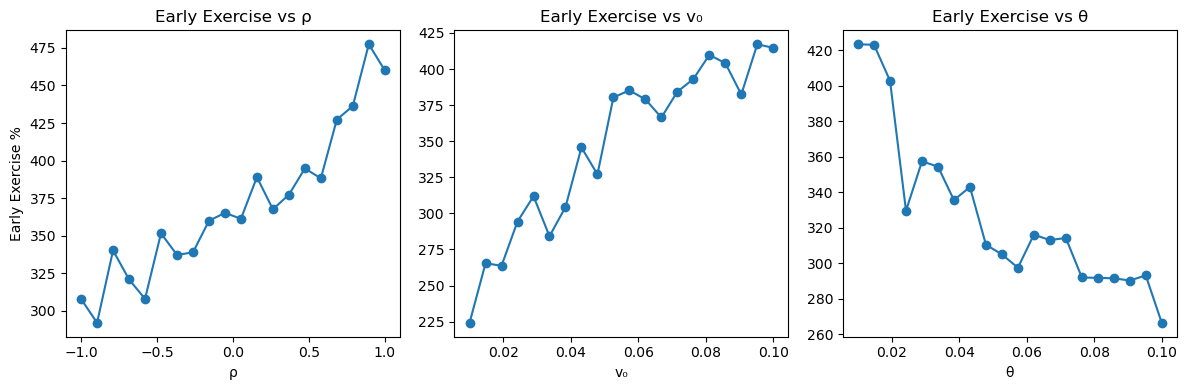

In [4]:
# Combine for export
df_sensitivity = pd.concat([df_rho, df_v0, df_theta], keys=["rho", "v0", "theta"], names=["Parameter"])
print("\nSensitivity Analysis Summary:")
# print(df_sensitivity)

# Optional plot: Early Exercise vs rho
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(df_rho["rho"], df_rho["Early Exercise %"], marker='o')
plt.title("Early Exercise vs ρ")
plt.xlabel("ρ")
plt.ylabel("Early Exercise %")

plt.subplot(1, 3, 2)
plt.plot(df_v0["v0"], df_v0["Early Exercise %"], marker='o')
plt.title("Early Exercise vs v₀")
plt.xlabel("v₀")

plt.subplot(1, 3, 3)
plt.plot(df_theta["theta"], df_theta["Early Exercise %"], marker='o')
plt.title("Early Exercise vs θ")
plt.xlabel("θ")

plt.tight_layout()
plt.show()


In [ ]:
# 
